## NannyML CBPE applied to SDSS quasar identification

In [10]:
import os, sys, time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from numpy_ext import rolling_apply

try:
    from sklearnex import patch_sklearn, get_patch_names
    patch_sklearn('random_forest_classifier')

except:
    print('Intel Scikit-Learn extension not installed. Falling back to standard Scikit-Learn')
    

import sklearn
from sklearn.metrics import f1_score, r2_score, mean_absolute_percentage_error
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.calibration import CalibratedClassifierCV
import xgboost as xgb
import lightgbm as lgb
from catboost import CatBoostClassifier

import dask
import dask.dataframe as dd

import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning) 
pd.options.mode.chained_assignment = None

Intel(R) Extension for Scikit-learn* enabled (https://github.com/intel/scikit-learn-intelex)


In [11]:
#from NannyML
#https://github.com/NannyML/nannyml/blob/main/nannyml/performance_estimation/confidence_based/cbpe.py

def estimate_f1(y_pred: pd.Series, y_pred_proba: pd.Series) -> float:
    tp = np.where(y_pred == 1, y_pred_proba, 0)
    fp = np.where(y_pred == 1, 1 - y_pred_proba, 0)
    fn = np.where(y_pred == 0, y_pred_proba, 0)
    TP, FP, FN = np.sum(tp), np.sum(fp), np.sum(fn)
    metric = TP / (TP + 0.5 * (FP + FN))
    return metric


In [12]:
# load the data
path = '/home/ajh/Documents/python_codes/machine_learning/nannyML/datasets/sdss/'
df = dd.read_csv(path+'sdss_test_large_andrew_humphrey.csv')

# drop rows with missing values
df=df.replace(-9999.0,np.nan).dropna(how = 'any')

In [13]:
# undersample to make model training more tractable
df = df.loc[::10]
print(len(df))

351089


In [14]:
# some rudimentary feature engineering:
# create a feature that is indicative of the size of a source on the sky:
df['modelMag_r-fiberMag_r'] = df['modelMag_r']-df['fiberMag_r']

# create colours:
bands = ['u','g','r','i','z']
for i,b1 in enumerate(bands[:-1]):
    for b2 in bands[i+1:]:
        df['modelMag_'+b1+'-modelMag_'+b2] = df['modelMag_'+b1] - df['modelMag_'+b2]

print(df.columns.values)

['objid' 'ra' 'dec' 'Redshift' 'fiberMag_u' 'petroMag_u' 'modelMag_u'
 'psfMag_u' 'fiberMag_g' 'petroMag_g' 'modelMag_g' 'psfMag_g' 'fiberMag_r'
 'petroMag_r' 'modelMag_r' 'psfMag_r' 'fiberMag_i' 'petroMag_i'
 'modelMag_i' 'psfMag_i' 'fiberMag_z' 'petroMag_z' 'modelMag_z' 'psfMag_z'
 'class' 'modelMag_r-fiberMag_r' 'modelMag_u-modelMag_g'
 'modelMag_u-modelMag_r' 'modelMag_u-modelMag_i' 'modelMag_u-modelMag_z'
 'modelMag_g-modelMag_r' 'modelMag_g-modelMag_i' 'modelMag_g-modelMag_z'
 'modelMag_r-modelMag_i' 'modelMag_r-modelMag_z' 'modelMag_i-modelMag_z']


In [15]:
cols_ml = [x for x in df.columns.values.tolist() if 'Mag_' in x]
df = df.compute()
df['class']

0         GALAXY
10        GALAXY
20        GALAXY
30           QSO
40           QSO
           ...  
161460    GALAXY
161470       QSO
161480       QSO
161490      STAR
161500    GALAXY
Name: class, Length: 351089, dtype: object

In [16]:
# sort by RA
df=df.sort_values(by=['ra'])
df

,objid,ra,dec,Redshift,fiberMag_u,petroMag_u,modelMag_u,psfMag_u,fiberMag_g,petroMag_g,...,modelMag_u-modelMag_g,modelMag_u-modelMag_r,modelMag_u-modelMag_i,modelMag_u-modelMag_z,modelMag_g-modelMag_r,modelMag_g-modelMag_i,modelMag_g-modelMag_z,modelMag_r-modelMag_i,modelMag_r-modelMag_z,modelMag_i-modelMag_z
106310,1237679504318922907,0.001661,20.397911,0.169639,23.19317,24.06787,23.09053,22.82628,22.08305,22.35545,...,0.93142,1.18984,1.11208,1.57977,0.25842,0.18066,0.64835,-0.07776,0.38993,0.46769
85930,1237679477470265897,0.001699,22.313928,-0.000842,22.40629,21.80065,21.93820,21.91749,21.26552,21.00201,...,1.03176,1.42015,1.58159,1.58350,0.38839,0.54983,0.55174,0.16144,0.16335,0.00191
88680,1237679478007202593,0.003054,22.654332,0.687130,23.72759,20.56767,22.96340,23.26116,23.81548,22.47039,...,0.25837,2.29204,3.48837,4.19817,2.03367,3.23000,3.93980,1.19633,1.90613,0.70980
122220,1237656495113633949,0.004698,14.666738,0.494372,24.64123,27.72672,24.16196,24.22452,22.79229,21.48647,...,2.14622,3.96156,4.89292,5.30700,1.81534,2.74670,3.16078,0.93136,1.34544,0.41408
178342,1237657191978959047,0.004742,0.708960,0.652078,22.79361,22.60482,20.88348,22.85150,22.60140,20.66000,...,0.56076,1.28619,2.00339,1.88960,0.72543,1.44263,1.32884,0.71720,0.60341,-0.11379
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
206160,1237680297281127272,359.996771,21.785129,0.403197,25.55326,23.06392,26.63804,26.12176,22.29978,21.04331,...,5.63014,7.61149,8.32248,8.74460,1.98135,2.69234,3.11446,0.71099,1.13311,0.42212
245641,1237663306917741344,359.997392,29.784564,2.181215,22.86479,22.65849,22.53520,22.41355,21.84419,21.55383,...,1.11071,1.41677,1.49492,2.14227,0.30606,0.38421,1.03156,0.07815,0.72550,0.64735
86230,1237663784197357819,359.997663,0.144871,1.355421,20.82982,20.60065,20.50475,20.45739,20.79091,20.53729,...,-0.01320,0.21841,0.22166,0.16939,0.23161,0.23486,0.18259,0.00325,-0.04902,-0.05227
238840,1237669768154054658,359.997837,8.470280,2.683349,18.47355,18.20370,18.16550,18.17316,18.54374,18.27373,...,-0.06948,-0.36008,-0.60637,-0.78399,-0.29060,-0.53689,-0.71451,-0.24629,-0.42391,-0.17762


In [17]:
df['isStar'] = np.where(df['class']=='STAR',1,0)
df['isQSO'] = np.where(df['class']=='QSO',1,0)
df['isGalaxy'] = np.where(df['class']=='GALAXY',1,0)

In [18]:
df_train = df.iloc[::40]
df_drift = df[~df.index.isin(df_train.index)]

ra_lims=[150,200]

train = df_train[(df_train.ra > ra_lims[0]) & (df_train.ra < ra_lims[1])]
val = df_drift[(df_drift.ra > ra_lims[0]) & (df_drift.ra < ra_lims[1])]

# set up a dictionary of ML models
model_dict = {'rf': RandomForestClassifier(n_estimators=100,max_depth=4,n_jobs=3),
            'xgb': xgb.XGBClassifier(n_estimators=300, max_depth=4, tree_method='hist',
                                     eval_metric='map',reg_alpha=0,reg_lambda=1,
                                     nthread=3),
            'lgbm': lgb.LGBMClassifier(n_jobs = 3,colsample_bytree = 0.9,
                                       n_estimators=1000,max_depth = 10,
                                       learning_rate = 0.01, subsample = 0.8)}

In [19]:
%%time

# define several different data subsets

df_train = df.iloc[::40]
df_drift = df[~df.index.isin(df_train.index)]

# define RA range used to train the models
ra_lims=[150,200]

# 1. train set
train = df_train[(df_train.ra > ra_lims[0]) & (df_train.ra < ra_lims[1])]

#2. validation set (same RA range as train, but no examples are in train set)
val = df_drift[(df_drift.ra > ra_lims[0]) & (df_drift.ra < ra_lims[1])]

# 3. test set (examples from outside the train / validation set regions)
df_drift_no_val = df_drift[~df_drift.index.isin(val.index)]

# 4. subset of examples in an RA range containing the Milky Way
df_mw = df_drift[(df_drift.ra > 260) & (df_drift.ra < 320)]

# data structure fo hold model scores
scores_dict = {}

# loop through the models
for key in model_dict:
    
    print('model: '+key)
    scores_dict[key] = {}
    
    # train a classifier which will return isotonically calibrated probabilities
    clf = model_dict[key]
    clf = CalibratedClassifierCV(base_estimator=clf,method = 'isotonic')
    clf.fit(train[cols_ml],train['isQSO'])

    # predict class probabilities (calibrated) on different data subsets 
    preds = clf.predict(df_drift[cols_ml])
    preds_proba = clf.predict_proba(df_drift[cols_ml])[:,1]
    
    preds_ref = clf.predict(val[cols_ml])
    preds_proba_ref = clf.predict_proba(val[cols_ml])[:,1]
    
    preds_no_train_no_val = clf.predict(df_drift_no_val[cols_ml])
    preds_proba_no_train_no_val = clf.predict_proba(df_drift_no_val[cols_ml])[:,1]
    
    preds_mw = clf.predict(df_mw[cols_ml])
    preds_proba_mw = clf.predict_proba(df_mw[cols_ml])[:,1]
    
    # add F1-scores to scores_dict
    scores_dict[key] = {'F1_ref': f1_score(val['isQSO'],preds_ref),
                        'F1_all': f1_score(df_drift['isQSO'],preds),
                        'f1_all_estimated': estimate_f1(preds,preds_proba),
                        'F1_no_val': f1_score(df_drift_no_val['isQSO'],preds_no_train_no_val),
                        'F1_no_val_estimated': estimate_f1(preds_no_train_no_val,preds_proba_no_train_no_val),
                        'F1_mw':f1_score(df_mw['isQSO'],preds_mw),
                        'F1_mw_estimated': estimate_f1(preds_mw,preds_proba_mw),
                        }
    
    # estimate F!-scores in rolling window
    df_drift['F1_estimated_'+key] = rolling_apply(estimate_f1,1001,preds,preds_proba,n_jobs=3)
    df_drift['F1_estimated_'+key].shift(-500)
    
    # calculate actual F1-scores in the rolling window
    df_drift['F1_score_'+key] = rolling_apply(f1_score,1001,df_drift['isQSO'],preds,n_jobs=3)
    df_drift['F1_score_'+key].shift(-500)



model: rf
model: xgb
model: lgbm
CPU times: user 9min 46s, sys: 9.37 s, total: 9min 55s
Wall time: 10min 29s


model F1_ref F1_notRef F1_notRef_est F1_mw F1_mw_est
rf 0.7691 0.7619 0.7642 0.6412 0.5446
xgb 0.7954 0.7783 0.7354 0.6527 0.4978
lgbm 0.7953 0.7804 0.7431 0.6732 0.4971


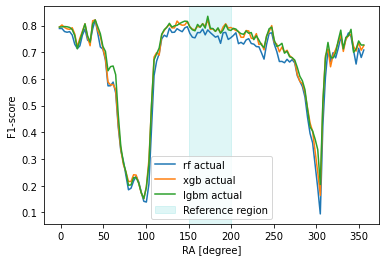

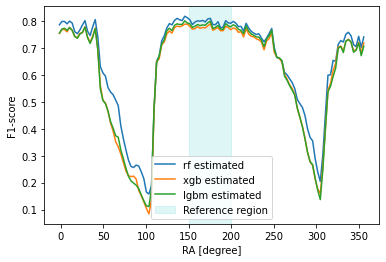

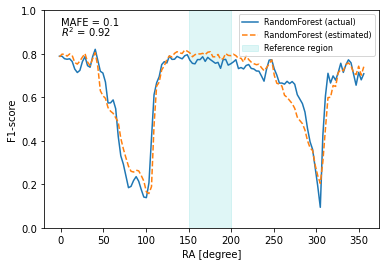

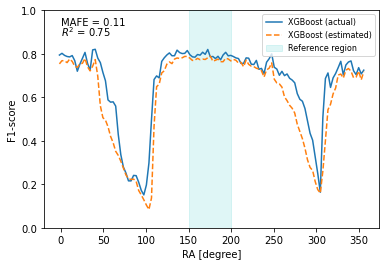

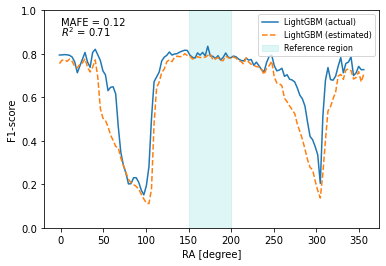

In [20]:
# determine scores in reference  window

names_dict = {'rf': 'RandomForest',
             'xgb': 'XGBoost',
             'lgbm': 'LightGBM'}

print('model','F1_ref','F1_notRef','F1_notRef_est','F1_mw','F1_mw_est')
for item in scores_dict:

    print(item,scores_dict[item]['F1_ref'].round(4),scores_dict[item]['F1_no_val'].round(4),
         scores_dict[item]['F1_no_val_estimated'].round(4),
          scores_dict[item]['F1_mw'].round(4),scores_dict[item]['F1_mw_estimated'].round(4))

resampled_ra = []
ra_step = 3
ra_edges = np.arange(0,360+ra_step,ra_step)
for ra in ra_edges[:-1]:
    resampled_ra.append(ra-(0.5*ra_step))

# plot F1-scores
for key in model_dict:
    resampled_f1 = []
    
    # resample
    for ra in ra_edges[:-1]:
        resampled_f1.append(df_drift['F1_score_'+key][(df_drift.ra >=ra) & (df_drift.ra < ra+ra_step)].mean())
    
    plt.plot(resampled_ra,resampled_f1,label=key+' actual')

plt.axvspan(ra_lims[0],ra_lims[1], alpha=0.125, color='c',label='Reference region')

plt.xlabel('RA [degree]')
plt.ylabel('F1-score')
plt.legend()
plt.show()


for key in model_dict:
    
    resampled_f1 = []
    for ra in ra_edges[:-1]:
        resampled_f1.append(df_drift['F1_estimated_'+key][(df_drift.ra >=ra) & (df_drift.ra < ra+ra_step)].mean())
    plt.plot(resampled_ra,resampled_f1,label=key+' estimated')

plt.axvspan(ra_lims[0],ra_lims[1], alpha=0.125, color='c',label='Reference region')

plt.xlabel('RA [degree]')
plt.ylabel('F1-score')
plt.legend()
plt.show()

# show estimated vs actual score:
for key in model_dict:
    
    resampled_f1 = []
    for ra in ra_edges[:-1]:
        resampled_f1.append(df_drift['F1_score_'+key][(df_drift.ra >=ra) & (df_drift.ra < ra+ra_step)].mean())
    plt.plot(resampled_ra,resampled_f1,label=names_dict[key]+' (actual)')
    
    resampled_f1_est = []
    for ra in ra_edges[:-1]:
        resampled_f1_est.append(df_drift['F1_estimated_'+key][(df_drift.ra >=ra) & (df_drift.ra < ra+ra_step)].mean())
    plt.plot(resampled_ra,resampled_f1_est,label=names_dict[key]+' (estimated)',ls='--')

    plt.axvspan(ra_lims[0],ra_lims[1], alpha=0.125, color='c',label='Reference region')

    plt.xlabel('RA [degree]')
    plt.ylabel('F1-score')
    plt.legend(loc='upper right',fontsize=8)
    plt.ylim([0,1])
    
    mape = mean_absolute_percentage_error(resampled_f1,resampled_f1_est)
    r2 = r2_score(resampled_f1,resampled_f1_est)
    plt.annotate('MAFE = '+str(mape.round(2))[:5],(0,0.93))
    plt.annotate('$R^2$ = '+str(r2.round(2))[:5],(0,0.88))
    
    # uncomment the next two lines (and comment out plt.show() to save as a .pdf)
    #plt.savefig(path+key+'_F1_actual_vs_estimated.pdf')
    #plt.close()
    
    plt.show()
